In [1]:
%pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.8/784.8 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 60.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 822.9/822.9 kB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 69.2 

In [2]:
%cd /notebooks/hpi-porsche-challenge/

/notebooks/hpi-porsche-challenge


In [3]:
import numpy as np
from darts import TimeSeries
import pandas as pd

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.datasets import AirPassengersDataset, EnergyDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood
from darts.models import NaiveSeasonal
from darts.metrics import rmse
from darts.models import *

import warnings

warnings.filterwarnings("ignore")
import logging

import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries



In [4]:
SEED = 42

In [5]:
data = pd.read_parquet("time-series-model/data/processed/energy_data_processed.parquet")
data.set_index("timestamp", inplace=True)
data = data[data.columns].astype(float)
series = TimeSeries.from_dataframe(data, fill_missing_dates=True, fillna_value=0)

#series = Scaler().fit_transform(series)

test_split = 0.15
val_split=0.15
train_end_index = (1 - val_split - test_split) * len(series)
val_end_index = (1 - test_split) * len(series)
train_end_index, val_end_index = int(train_end_index), int(val_end_index)

print(train_end_index, val_end_index)

train, val, test = series[:train_end_index], series[train_end_index:val_end_index], series[val_end_index:]

50585 61425


In [12]:
len(train)

50585

Number of components is larger than 10 (12). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


Text(0.5, 1.0, 'Data')

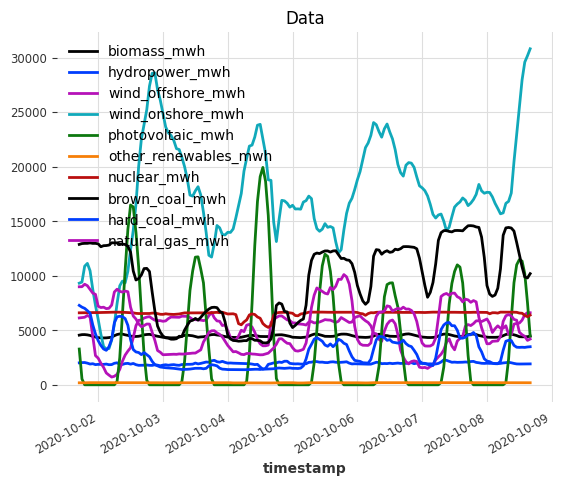

In [6]:
plt.figure()
train[-24*7:].plot()
plt.title("Data")

Text(0.5, 1.0, 'Covariates')

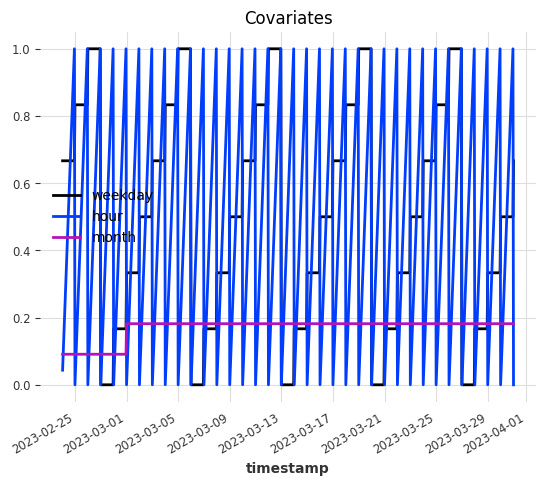

In [16]:
weekday = datetime_attribute_timeseries(series, attribute="weekday")
month = datetime_attribute_timeseries(series, attribute="month")
hour = datetime_attribute_timeseries(series, attribute="hour")
covariates = weekday.stack(hour).stack(month)

scaler_covariates = Scaler()
covariates = scaler_covariates.fit_transform(
    covariates
)

plt.figure()
covariates[-5*7*24:].plot()
plt.title("Covariates")

In [20]:
def eval_model(model):
    
    covariate_args = {}
    covariate_args_inference = {}
    if model.supports_past_covariates:
        covariate_args['past_covariates'] = covariates
        covariate_args['val_past_covariates'] = covariates
        covariate_args_inference['past_covariates'] = covariates
    if model.supports_future_covariates:
        covariate_args['future_covariates'] = covariates
        covariate_args['val_future_covariates'] = covariates
        covariate_args_inference['future_covariates'] = covariates
        
    model.fit(series=train, val_series=val, **covariate_args)
    forecast = model.predict(len(test), series=val, **covariate_args_inference)
    
    test_rmse = rmse(test, forecast)
    print(f"model {model} obtains RMSE: {test_rmse:.2f}")
    
    #plt.figure()
    #forecast[:7*24].plot()
    #test[:7*24].plot()
    #plt.title(str(model))
    #plt.show()

eval_model(RNNModel(model="LSTM", input_chunk_length=24*7, training_length=24*7*4, hidden_dim=16, dropout=0.2, n_rnn_layers=2, n_epochs=1, force_reset=True))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 4.3 K 
4 | V             | Linear           | 204   
---------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

model RNNModel(model=LSTM, hidden_dim=16, n_rnn_layers=2, dropout=0.2, training_length=672, input_chunk_length=168, n_epochs=1, force_reset=True) obtains RMSE: 5719.83
